<center><h1> Aplicación de los Métodos de Agrupamiento</h1></center>
<center><h1> Aprendizaje No Supervisado</h1></center>
<center><h1> Agrupamiento Espectral : Matriz Laplaciana</h1></center>
<br>

### - Alexandro López González
### - Leonardo Pacheco Garduño
### - Manuel Garcia Sanes
<br>
<br>

En este notebook, realizaremos los siguiente:

- Aplicación del algoritmo Matriz Laplaciana  a los dos datasets seleccionados. 

- Evaluación de los resultados utilizando métricas intrínsecas o extrínsecas según sea el caso

- Análisis del resultado
<br>
<br>


## 1. Cargamos las librerias necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.cluster import KMeans

## 2. Cargamos el dataset con agrupamiento conocido

**Nombre:<br>

SEEDS<br>

**Abstract: 

Measurements of geometrical properties of kernels belonging to three different varieties of wheat. A soft X-ray technique and GRAINS package were used to construct all seven, real-valued attributes.<br>

**Atributos (Reales): <br>

area A,<br>
perimeter P,<br>
compactness C = 4piA/P^2,<br>
length of kernel,<br>
width of kernel,<br>
asymmetry coefficient<br>
length of kernel groove. All of these parameters were real-valued continuous.<br>

**Instancias:**<br>

210<br>

URL:<br>
https://archive.ics.uci.edu/ml/datasets/seeds#



El dataset cargado tiene 210 instancias, 7 atributos y 3 clusters.


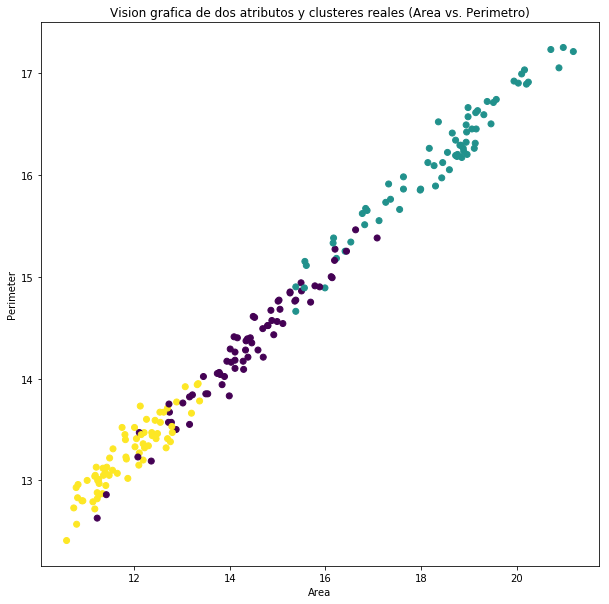

In [2]:
#Cargamos los datos
data_file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt'

#Mezclamos y separamos la columa clase  
D = np.array(pd.read_csv(data_file_url,delimiter='\s+', header=None))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:-1]
Dy = D[:,-1]

#Graficamos la parej de atributos seleccionada:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(Dx[:, 0], Dx[:, 1], c=Dy)
ax.set_xlabel("Area")
ax.set_ylabel("Perimeter")
ax.set_title("Vision grafica de dos atributos y clusteres reales (Area vs. Perimetro)")

print()

print('El dataset cargado tiene',Dx.shape[0],'instancias,', Dx.shape[1], 'atributos y' ,len(np.unique(Dy)) , 'clusters.')


## 2.1 Aplicamos el Algoritmo seleccinado: Laplace

Con este dataset trabajaremos y estudiaremos en esta práctica el agrupamiento espectral y sus diferentes configuraciones. Para empezar, será necesario calcular la matriz de similitudes. Para ello, usaremos la función de la libreria Scikit-learn para obtener la matriz de distancias, concretamente, usando la métrica euclidiana. 

Para transformar la matriz de distancias en una de similitudes se usa la función exponencial de la siguiente manera:


In [3]:
from sklearn.metrics.pairwise import euclidean_distances

mSimilitud = euclidean_distances(Dx)

sigma = 0.1
mSimilitud = np.exp(-np.power(mSimilitud,2)/(2*sigma**2))


Tal y como se ha visto en la parte teórica, el agrupamiento espectral consiste en 4 pasos básicos: la obtención de la matriz de adyacencias o afinidad, la obtención de la matriz Laplaciana, el cálculo de los vectores y valores propios de esta última, y el clustering mediante K-means (u otra técnica tradicional). Iremos paso a paso revisando los diferentes pasos.

Para comenzar, calcularemos la matriz de afinidad completa, que contempla que todos los ejemplos (nodos) están conectados con todos:


In [4]:
def matriz_afinidad_completa(mSimilitud):
    mAfinidad = mSimilitud 
    return mAfinidad


La matriz de afinidad mediante umbral sólo conecta aquellos nodos cuya similitud sea mayor que cierto umbral fijado. Todos aquellos pares de ejemplos (nodos) que superen el umbral reciben como valor $W_{ij}$ el valor de similitud correspondiente, y 0 cuando no están conectados:


In [5]:
def matriz_afinidad_umbral(mSimilitud, umbral=0.1):
    mAfinidad = np.zeros(mSimilitud.shape)
    mAfinidad[mSimilitud >= umbral] = mSimilitud[mSimilitud >= umbral]
    return mAfinidad


La matriz de afinidad mediante KNN sólo conecta aquellos nodos que sean uno de los ($K$) vecinos más cercanos (similares) entre ellos. Todos aquellos pares de ejemplos (nodos) que sean vecinos cercanos reciben como valor $W_{ij}$ el valor de similitud correspondiente, y 0 cuando no están conectados. Otra alternativa es calcular dos matrices, $W^1$ y $W^2$, tal que $W^1_{ij}$ toma valor 1 cuando el nodo $j$ es uno de los $K$ vecinos más similares de $i$, y $W^2_{ij}$ toma valor 1 cuando el nodo $i$ es uno de los K vecinos más similares de $j$. La matriz de afinidad devuelta sería $(W^1+W^2)/2$:


In [6]:
def matriz_afinidad_KNN(mSimilitud, KNN=5):
    auxM = mSimilitud.copy()
    np.fill_diagonal(auxM, 0)

    mAfinidadA = np.zeros(auxM.shape)
    a = (np.argsort(-auxM, axis=0)[0:KNN,:]).flatten()
    b = np.tile(np.arange(auxM.shape[0]),KNN)
    mAfinidadA[a,b] = 1
    np.fill_diagonal(mAfinidadA, 1)

    mAfinidadB = np.zeros(auxM.shape)
    a = np.repeat(np.arange(auxM.shape[0]),KNN)
    b = (np.argsort(-auxM, axis=1)[:,0:KNN]).flatten()
    mAfinidadB[a,b] = 1
    np.fill_diagonal(mAfinidadB, 1)

    return (mAfinidadA+mAfinidadB)/2


Una vez obtenida la matriz de afinidad, el siguiente paso es calcular una matriz Laplaciana. Como se ha visto en la parte teórica, hay tres manera de hacerlo.

La matriz Laplaciana no normalizada tiene, en cada celda $L_{ij}$, con $i\neq j$, el valor $-W_{ij}$, y en su diagonal principal $L_{ii}=D_{i}$, donde $D_i$ es la suma de $W_{ij}$ para toda la fila (para todo $j$):


In [7]:
def matriz_Laplaciana(mAfinidad):
    R = -mAfinidad.copy()
    np.fill_diagonal(R, np.sum(mAfinidad,axis=1)-1)
    return R


La matriz Laplaciana normalizada (o de camino aleatorio) se calcula como la diferencia entre la matriz identidad y el producto de la inversa de la matriz diagonal de grado, $D$, y la matriz de afinidad:


In [8]:
def matriz_Laplaciana_normalizada(mAfinidad):
    D = np.sum(mAfinidad,axis=1)
    D = D**(-1)
    I = np.diag( np.ones(D.size) )
    D = np.diag(D)
    return I - D.dot(mAfinidad)


Para obtener la matriz Laplaciana normalizada simétrica se calcula, $D'$ la inversa de la raiz cuadrada de la matriz diagonal de grado, $D$. El resultado final se obtiene tras calcular la diferencia entre la matriz identidad y el producto de $D'$, la matriz de afinidad y $D'$ de nuevo:


In [9]:
def matriz_Laplaciana_normalizada_simetrica(mAfinidad):
    D = np.sum(mAfinidad,axis=1)
    D = D**(-1.0/2)
    I = np.diag( np.ones(D.size) )
    D = np.diag(D)
    return I - D.dot(mAfinidad).dot(D)


Con esto, sólo nos queda obtener los valores y vectores propios de la matriz Laplaciana, para lo que usaremos la función eig de la libraría scipy. Los primeros vectores propios, ordenados según su valor propio correspondiente, se recogen y se usan como variables de nuestro nuevo dataset, el conjunto de datos transformado que usaremos posteriormente para realizar el clustering K-means:


In [10]:
def agrupamiento_espectral(mSimilitud, K, afinidad = matriz_afinidad_completa, 
                           laplaciana = matriz_Laplaciana_normalizada, **kwargs):
    mAfinidad = afinidad(mSimilitud, **kwargs)
    mLaplaciana = laplaciana(mAfinidad)

    valores_pr, vectores_pr = linalg.eig(mLaplaciana)
    orden = valores_pr.real.argsort()
    vectores_pr = vectores_pr.real[:, orden]

    Dx_trans = vectores_pr[:, np.arange(K)]
    modelo = KMeans(n_clusters = K)
    modelo = modelo.fit(Dx_trans)
    Dyp = modelo.predict(Dx_trans)

    return [mAfinidad, Dyp]





Con esta última función, ya se puede proceder a realizar el agrupamiento:


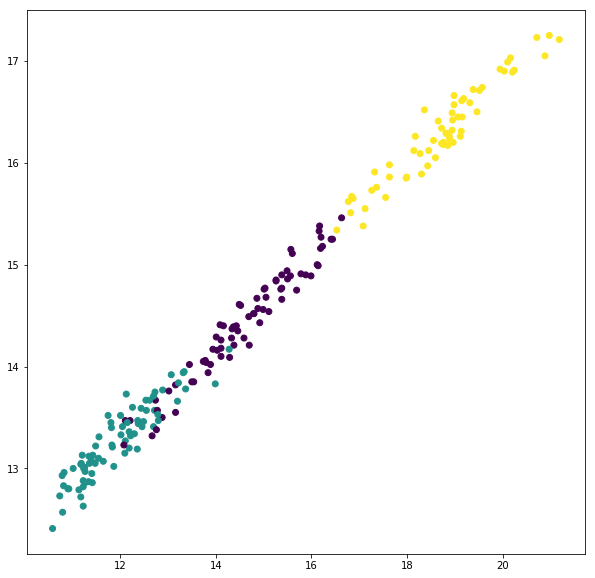

In [11]:
K = 3
knn = 40
mAfinidad, Dyp = agrupamiento_espectral(mSimilitud, K, 
                                        matriz_afinidad_KNN,
                                        matriz_Laplaciana_normalizada, KNN=knn)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
print("")

## 2.2 Evaluacion Extriniseca del Algoritmo seleccinado: K-means ++

- Matriz Confusion
- Informacion Mutua
- Valor de Error
- Pureza del Agrupamiento
- Precision
- Recall
- F1
- Entropia


In [12]:
def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i],cat_pred==clusts[j])) for j in np.arange(clusts.size)] for i in np.arange(cats.size)])
    return(mat)

def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def medida_precision(mat, l, k):
    return mat[l,k]/float(np.sum(mat[:,k]))

def medida_recall(mat, l, k):
    return mat[l,k]/float(np.sum(mat[l,:]))

def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    return np.sum([ float(np.sum(mat[:,k]))/float(np.sum(mat))
                   * np.max(mat[:,k]/float(np.sum(mat[:,k]))) for k in np.arange(mat.shape[1])])

def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return (2*prec*rec)/(prec+rec)

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign

def medida_entropia(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    relMat = mat/np.sum(mat,0)
    logRelMat = relMat.copy()
    logRelMat[logRelMat==0]=0.0001 # Evita el logaritmo de 0. Inofensivo pues luego desaparece al multiplicar por 0
    logRelMat = np.log(logRelMat)
    return -np.sum([totales[k] * np.sum([relMat[l,k]*logRelMat[l,k] 
                                         for l in np.arange(mat.shape[0])]) 
                    for k in np.arange(mat.shape[1])])

def medida_informacion_mutua(mat):
    relMat = mat/float(np.sum(mat))
    logRelMat = mat.copy()
    logRelMat = logRelMat/np.sum(mat,0,keepdims=True)
    logRelMat = logRelMat/np.sum(mat,1,keepdims=True)
    logRelMat[logRelMat==0]=0.000001 # Evita el logaritmo de 0. Inofensivo pues luego desaparece al multiplicar por 0
    logRelMat = np.log(float(np.sum(mat))*logRelMat) 
    return np.sum([np.sum([relMat[l,k]*logRelMat[l,k]
                           for l in np.arange(mat.shape[0])])
                   for k in np.arange(mat.shape[1])])

mC = matriz_confusion(Dy,Dyp)  
print("Matriz de Confusion")
print(mC)
print('La información mutua es = ', medida_informacion_mutua(mC))
print('El valor del error cometido es = ', medida_error(mC))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC))
print('Precision de l=1,k=1 es :' , medida_precision(mC,1,1))
print('Recall de l=1,k=1 es :' , medida_recall(mC,1,1))
print('El valor F1 es = ', medida_f1(mC))
print('La entropía es = ', medida_entropia(mC))

Matriz de Confusion
[[61  8  1]
 [10  0 60]
 [ 3 67  0]]
La información mutua es =  0.755849783666
El valor del error cometido es =  0.104761904762
La pureza del agrupamiento obtenido es =  0.895238095238
Precision de l=1,k=1 es : 0.0
Recall de l=1,k=1 es : 0.0
El valor F1 es =  0.895796895869
La entropía es =  0.342762505002


## 3. Cargamos el dataset con agrupamiento desconocido   

#### Nota: Por fines practicos, utlizaremos el mismo dataset, pero lo analizamos ignorando el conocimiento de su agrupamiento


## 3.1 Aplicamos el Algoritmo seleccinado: Laplace
 


## 3.1.1 Eleccion de K (Regla del Codo)

Realizamos la estimacion de K basado en los datos transformados

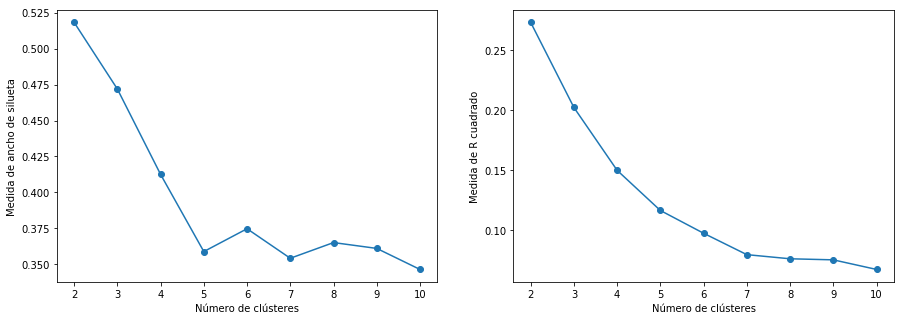

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


def medida_R_cuadrado(X, Xyp, cXs):
    cXglob = np.mean(X,axis=0) 
    labels = np.sort(np.unique(Xyp))
    sumTotal = np.sum(np.sum(X-cXglob,1)**2) 
    interior = np.sum([ np.sum(np.sum(X[Xyp==labels[k],:]-cXs[labels[k],:],1)**2) for k in np.arange(labels.size)])
    return interior/sumTotal 


def agrupamiento_espectral_estimacion_k(mSimilitud, afinidad = matriz_afinidad_completa, 
                           laplaciana = matriz_Laplaciana_normalizada, **kwargs):
    mAfinidad = afinidad(mSimilitud, **kwargs)
    mLaplaciana = laplaciana(mAfinidad)

    valores_pr, vectores_pr = linalg.eig(mLaplaciana)
    orden = valores_pr.real.argsort()
    vectores_pr = vectores_pr.real[:, orden]

    Dx_trans = vectores_pr[:, np.arange(K)]
 

    rsilueta = np.zeros(9)
    rrsquare = np.zeros(9)
    for k in np.arange(2,11):
        modelo = KMeans(n_clusters=k)
        modelo = modelo.fit(Dx)
        Dyp_sk = modelo.predict(Dx)
        cDx_sk = modelo.cluster_centers_
        rsilueta[k-2] = silhouette_score(Dx, Dyp_sk)
        rrsquare[k-2]  = medida_R_cuadrado(Dx, Dyp_sk, cDx_sk)

    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].plot( np.arange(2,11),rsilueta, linestyle='-', marker='o')
    ax[0].set_xlabel("Número de clústeres")
    ax[0].set_ylabel("Medida de ancho de silueta")

    ax[1].plot( np.arange(2,11),rrsquare, linestyle='-', marker='o')
    ax[1].set_xlabel("Número de clústeres")
    ax[1].set_ylabel("Medida de R cuadrado")



agrupamiento_espectral_estimacion_k(mSimilitud,matriz_afinidad_KNN,matriz_Laplaciana_normalizada, KNN=knn)



## 3.1.2 Aplicando Algoritmo (k=5) 


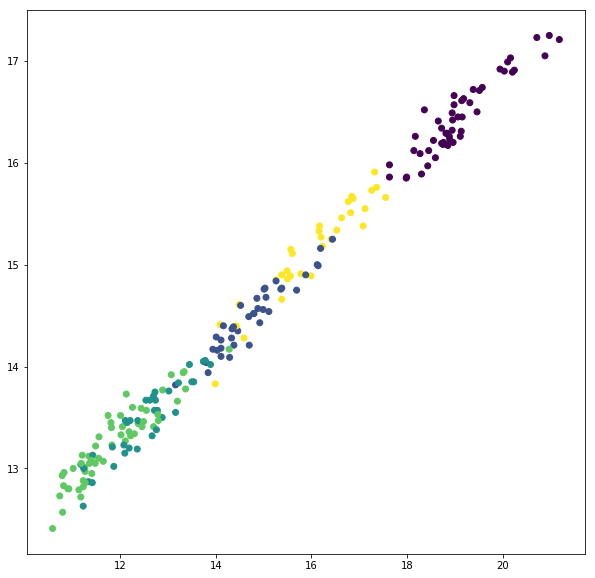

In [14]:
K = 5
knn = 40
mAfinidad, Dyp = agrupamiento_espectral(mSimilitud, K, 
                                        matriz_afinidad_KNN,
                                        matriz_Laplaciana_normalizada, KNN=knn)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
print("")

## 3.2 Evaluacion Intrinseca del Algoritmo seleccinado: Laplace

- Silueta
- Calinski-Harabasz
- Davies-Bouldin 

In [15]:


from sklearn.metrics import silhouette_score,calinski_harabaz_score , davies_bouldin_score ,r2_score

K = 5

print('La medida de Silueta con K =',K,'es',silhouette_score(Dx,Dyp))
print('La medida de Calinski Harabaz con K =',K,'es',silhouette_score(Dx,Dyp))
print('La medida de Davie Bouldin con K =',K,'es',davies_bouldin_score(Dx,Dyp))



La medida de Silueta con K = 5 es 0.366263982158
La medida de Calinski Harabaz con K = 5 es 0.366263982158
La medida de Davie Bouldin con K = 5 es 0.927095745999


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
